<a href="https://colab.research.google.com/github/Bharath2/cube/blob/master/Dircol_flexible_link8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**PyDrake Setup**

In [ ]:
import importlib
import sys
from urllib.request import urlretrieve

# Install drake (and underactuated).
if 'google.colab' in sys.modules and importlib.util.find_spec('underactuated') is None:
    urlretrieve(f"http://underactuated.csail.mit.edu/scripts/setup/setup_underactuated_colab.py",
                "setup_underactuated_colab.py")
    from setup_underactuated_colab import setup_underactuated
    setup_underactuated(underactuated_sha='15cfd96b0bdfd1b0c67597c24f91907776c02a6d', drake_version='0.27.0', drake_build='release')

!pip install recordclass

Cloning into '/opt/underactuated'...

HEAD is now at 15cfd96 and again

ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.7.1 which is incompatible.
ERROR: bokeh 2.3.1 has requirement pillow>=7.1.0, but you'll have pillow 7.0.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.




     |████████████████████████████████| 163kB 17.9MB/s 
  Created wheel for recordclass: filename=recordclass-0.14.3-cp37-cp37m-linux_x86_64.whl size=344680 sha256=6d8b9f32e6bf0997a6c0ef05a433125c6cd5793818fc86f016fda78739779b2c
  Stored in directory: /root/.cache/pip/wheels/c2/fa/9f/abec56a7c5d6843a053f2aa53166c556be33c169438c57e483
Successfully built recordclass


###setup meshcat server

In [ ]:
server_args = ['--ngrok_http_tunnel']

from meshcat.servers.zmqserver import start_zmq_server_as_subprocess
proc, zmq_url, web_url = start_zmq_server_as_subprocess(server_args=server_args)

#**import modules**

In [ ]:
import time
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from itertools import count


from pydrake.all import (
    DiagramBuilder, SceneGraph, Simulator, RigidTransform, 
    AddMultibodyPlantSceneGraph, Parser, RotationMatrix, PlanarSceneGraphVisualizer,
    LeafSystem, BasicVector, RevoluteSpring, AddTriad, RollPitchYaw
)

import pydrake.systems.meshcat_visualizer as meshcat_visualizer

#**URDF**

In [ ]:
!pip install xacro

In [ ]:
%%file model
<?xml version="1.0"?>

<robot xmlns:xacro="http://www.ros.org/wiki/xacro" name="RR">

  <xacro:macro name="Link" params="id damping color">
  <link name="link${id}">
    <inertial>
      <origin xyz="0 0 0" rpy="0 0 0" />
      <mass value="0.25" />
      <inertia ixx="0.125" ixy="0" ixz="0" iyy="0.125" iyz="0" izz="0.125" />
    </inertial>
    <visual>
      <origin xyz="0.125 0 0" rpy="0 0 0" />
      <geometry>
        <box size="0.25 0.1 0.05"/>
      </geometry>
      <material>
        <color rgba="${color} 1" />
      </material>
    </visual>
  </link>

  <joint name="theta${id}" type="continuous">
    <parent link="link${id-1}" />
    <child link="link${id}" />
    <origin rpy="0 0 0" xyz="0.25 0 0" />
    <axis xyz="0 0 1" />
    <dynamics damping="${damping}" />
  </joint>

  </xacro:macro>

  <link name="link0">
    <visual>
      <origin xyz="0.25 0 -0.25" rpy="0 0 0" />
      <geometry>
        <cylinder length=".1" radius=".053"  />
      </geometry>
      <material>
        <color rgba="0.5 0.5 0.5 1" />
      </material>
    </visual>
  </link>

  <joint name="fixed1" type="fixed">
    <parent link="world" />
    <child link="link0" />
  </joint>

  <xacro:Link id = "1" damping = "0.1" color = "0.2 0.3 0.9"/>
  <xacro:Link id = "2" damping = "0.1" color = "0.9 0.3 0.2"/>
  <xacro:Link id = "3" damping = "0.1" color = "0.2 0.3 0.9"/>
  <xacro:Link id = "4" damping = "0.1" color = "0.9 0.3 0.2"/>
  <xacro:Link id = "5" damping = "0.1" color = "0.2 0.3 0.9"/>
  <xacro:Link id = "6" damping = "0.1" color = "0.9 0.3 0.2"/>
  <xacro:Link id = "7" damping = "0.1" color = "0.2 0.3 0.9"/>
  <xacro:Link id = "8" damping = "0.1" color = "0.9 0.3 0.2"/>

  <transmission type="SimpleTransmission" name="j1">
    <actuator name="torque1" />
    <joint name="theta1" />
    <mechanicalReduction>1</mechanicalReduction>
  </transmission>

</robot>

Overwriting model


In [ ]:
!xacro model -o model.urdf

No module named 'rosgraph'



#Flexible Env class based on pydrake simulator

* joint damping coeff: 1 N.m.s

* joint stiffness: 5 N/m

In [ ]:
def angle_normalize(x):
    return (((x+np.pi) % (2*np.pi)) - np.pi)/np.pi

class FlexibleEnv():

  def __init__(self):
    self.Setup()
    self.reset()

  def Setup(self, visualize = False):
    builder = DiagramBuilder()
    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step = 0.0)
    parse_ins = Parser(plant).AddModelFromFile('./model.urdf')
    #Add Revolute spring
    for i in range(2,9):
      plant.AddForceElement(RevoluteSpring(plant.GetJointByName(f"theta{i}", parse_ins), 0, 5))
    plant.Finalize()
    self.plant = plant

    # Setup visualization
    self.visualizer = None
    if visualize:
      self.visualizer = meshcat_visualizer.ConnectMeshcatVisualizer(
                builder, 
                scene_graph = scene_graph, 
                zmq_url = zmq_url, 
                delete_prefix_on_load=True)
      #set planar view instead of 3d view
      self.visualizer.set_planar_viewpoint(camera_position=[0, 0, 1], 
                                  xmin=-3, xmax=1, ymin=-2, ymax=2)
    
    self.diagram = builder.Build()


  def reset(self, init_state = None):
    #reset time and simulator
    self.time = 0
    self.context = self.diagram.CreateDefaultContext()
    self.plant_context = self.plant.GetMyMutableContextFromRoot(self.context)
    self.simulator = Simulator(self.diagram, self.context)
    #set initial state
    self.set_state(init_state)
    return self.get_state
  
  def set_state(self, init_state = None):
    if not init_state:
      init_state = np.random.uniform(-1,1,4)
      init_state = init_state * [np.pi, 1, np.pi/6, 0.1]
    init_state = [init_state[0]] + [init_state[1]/3]*7 + [init_state[2]] + [init_state[3]/3]*7
    self.plant_context.SetContinuousState(init_state)

  @property
  def get_state(self):
    #get current state from plant
    state = self.plant.get_state_output_port().Eval(self.plant_context)
    state[0] = angle_normalize(state[0])
    return state
  

  def step(self, u, dt = 0.05):
    #Set joint torque with input
    self.plant.get_actuation_input_port().FixValue(self.plant_context, u)
    #Advance to next step
    self.simulator.AdvanceTo(self.time + dt)
    self.time += dt
    #return current state
    return self.get_state
  
  
  def start_recording(self, init_state = None):
    self.Setup(True)
    self.reset(init_state)
    self.visualizer.load()
    self.visualizer.start_recording()
  
  def stop_recording(self):
    self.visualizer.stop_recording()
    self.visualizer.publish_recording()

  def render(self, model, init_state = None):
    self.start_recording(init_state)
    
    for i in range(200):
      u = model(self.get_state)
      self.step(u)
    
    self.stop_recording()


##**Test Env**

In [ ]:
env = FlexibleEnv()

In [ ]:
from pydrake.all import (DirectCollocation, PiecewisePolynomial, Solve, TrajectorySource, MultibodyPlant)

plant = MultibodyPlant(time_step=0.0)
scene_graph = SceneGraph()
plant.RegisterAsSourceForSceneGraph(scene_graph)
parse_ins = Parser(plant).AddModelFromFile('./model.urdf')

#Add Revolute spring
for i in range(2,9):
  plant.AddForceElement(RevoluteSpring(plant.GetJointByName(f"theta{i}", parse_ins), 0, 5))
  
plant.Finalize()
context = plant.CreateDefaultContext()

array([-0.25,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ])

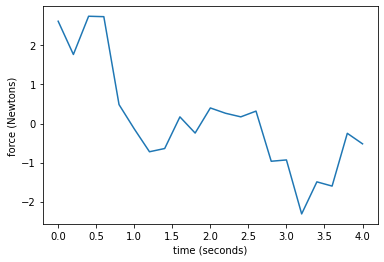

In [ ]:
dircol = DirectCollocation(plant,
                           context,
                           num_time_samples=16,
                           minimum_timestep=0.05,
                           maximum_timestep=0.3,
                           input_port_index=plant.get_actuation_input_port().get_index())


# Add input limits.
torque_limit = 4.0  # N*m.
u = dircol.input()
dircol.AddConstraintToAllKnotPoints(-torque_limit <= u[0])
dircol.AddConstraintToAllKnotPoints(u[0] <= torque_limit)

initial_state = [0.]*16
dircol.AddBoundingBoxConstraint(initial_state, initial_state,
                                dircol.initial_state())

final_state = [np.pi/2]+[0]*15
dircol.AddBoundingBoxConstraint(final_state, final_state, dircol.final_state())
# dircol.AddLinearConstraint(dircol.final_state() == final_state)

R = 10  # Cost on input "effort".
dircol.AddRunningCost(R * u[0]**2)

# Add a final cost equal to the total duration.
dircol.AddFinalCost(dircol.time())
dircol.AddEqualTimeIntervalsConstraints()

initial_x_trajectory = PiecewisePolynomial.FirstOrderHold([0., 4.], np.column_stack((initial_state, final_state)))
dircol.SetInitialTrajectory(PiecewisePolynomial(), initial_x_trajectory)

result = Solve(dircol)
assert (result.is_success())

u_trajectory = dircol.ReconstructInputTrajectory(result)
u_lookup = np.vectorize(u_trajectory.value)

In [ ]:
times = np.linspace(u_trajectory.start_time(), u_trajectory.end_time(), 101)
u_values = u_lookup(times)

plt.figure()
plt.plot(times, u_values)
plt.xlabel("time (seconds)")
plt.ylabel("force (Newtons)");

In [ ]:
#Simulate with learned policy
env = FlexibleEnv()

# print(env.get_state)
env.start_recording([0]*16)

prev_theta = 0

for i in range(101):
    env.step(u_values[i], 0.04)
  
env.stop_recording()

Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6004...
You can open the visualizer by visiting the following URL:
http://66ed246617d4.ngrok.io/static/
Connected to meshcat-server.
